In [ ]:
!pip install praw

     |████████████████████████████████| 176 kB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sns.set(style='darkgrid', context='talk', palette='Dark2')
from google.colab import files
from nltk.tokenize import word_tokenize, RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
import praw
import re
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import json
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:


 
reddit_read_only = praw.Reddit(client_id="J0gXE5pbtclPDeubLZPOrw",         # your client id
                               client_secret="NgTwhememWQVzm7QM-pFF10taOt8xA",      # your client secret
                               user_agent="GrImPiL_Sama")        # your user agent
 
 
subreddit = reddit_read_only.subreddit("bangladesh")

In [ ]:
print("Title:", subreddit.title)

Title: Bangladesh


In [ ]:
posts = subreddit.top("month")
# Scraping the top posts of the current month
 
posts_dict = {"Title": [], "Post URL": []}
 
for post in posts:
    # Title of each post
    posts_dict["Title"].append(post.title)
     
    posts_dict["Post URL"].append(post.url)
 
# Saving the data in a pandas dataframe
top_posts = pd.DataFrame(posts_dict)
top_posts

In [ ]:
headlines = set()

for submission in reddit_read_only.subreddit('bangladesh').new(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

970


In [ ]:
sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.1531,
  'headline': 'Why you need to be careful about the use of the word – chetona/চেতনা',
  'neg': 0.0,
  'neu': 0.882,
  'pos': 0.118},
 {'compound': 0.4201,
  'headline': 'So I like this girl and how should I tell her?',
  'neg': 0.0,
  'neu': 0.741,
  'pos': 0.259},
 {'compound': 0.0, 'headline': 'Career advice', 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


In [ ]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.0,0.882,0.118,0.1531,Why you need to be careful about the use of th...
1,0.0,0.741,0.259,0.4201,So I like this girl and how should I tell her?
2,0.0,1.000,0.000,0.0000,Career advice
3,0.0,0.605,0.395,0.6785,A Very Happy Victory Day to Bangladesh From In...
4,0.0,0.654,0.346,0.5719,New Years Celebrated on the Hill at Srimongal


In [ ]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,neg,neu,pos,compound,headline,label
0,0.0,0.882,0.118,0.1531,Why you need to be careful about the use of th...,0
1,0.0,0.741,0.259,0.4201,So I like this girl and how should I tell her?,1
2,0.0,1.000,0.000,0.0000,Career advice,0
3,0.0,0.605,0.395,0.6785,A Very Happy Victory Day to Bangladesh From In...,1
4,0.0,0.654,0.346,0.5719,New Years Celebrated on the Hill at Srimongal,1


In [ ]:
df2 = df[['headline', 'label']]
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

In [ ]:
files.download('reddit_headlines_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['So I like this girl and how should I tell her?',
 'A Very Happy Victory Day to Bangladesh From India!!',
 'New Years Celebrated on the Hill at Srimongal',
 'Should Khaleda Zia be allowed for better treatment abroad?',
 'How are we even surviving?']

Negative headlines:

['এত বিষণ্ণতা, এত chaos, সব একদিন ঠিক হয়ে যাবে তাই না?',
 'Should Bangladesh Still Keep Death Penalty?',
 'Interview of some survivors of the genocidal killings in Boroitola, Kishoreganj',
 'Where is the discord server link?',
 'Worst Rumor You Spread In Your School']


In [ ]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 0    618
 1    227
-1    125
Name: label, dtype: int64
 0    63.711340
 1    23.402062
-1    12.886598
Name: label, dtype: float64


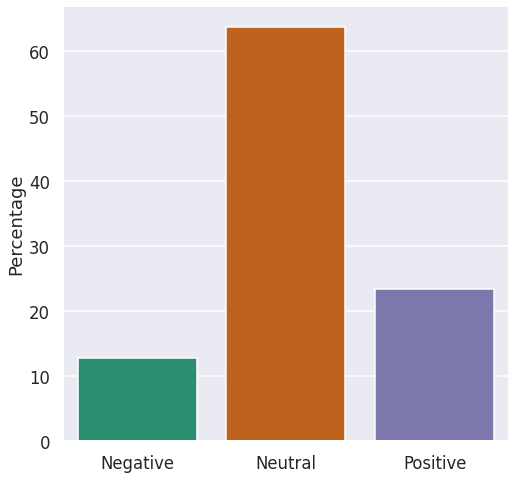

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

In [ ]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [ ]:
pos_lines = list(df[df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('bangladesh', 57),
 ('best', 21),
 ('dhaka', 19),
 ('good', 17),
 ('help', 16),
 ('bangladeshi', 15),
 ('would', 12),
 ('bangla', 12),
 ('like', 11),
 ('happy', 10),
 ('way', 10),
 ('anyone', 10),
 ('new', 9),
 ('country', 8),
 ('one', 8),
 ('bengali', 8),
 ('র', 8),
 ('india', 7),
 ('please', 7),
 ('need', 7)]

In [ ]:
pos_tokens

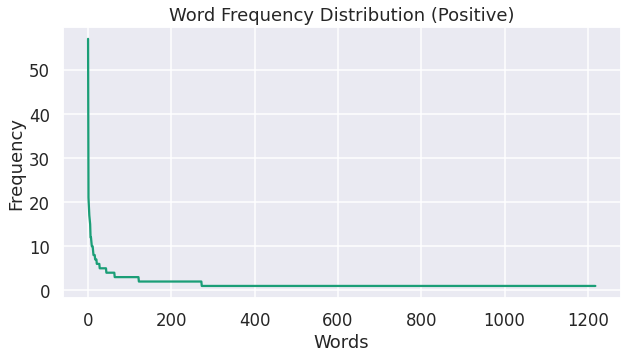

In [ ]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

In [ ]:
#The above chart is showing the frequency patterns, where the y-axis is the frequency of the words and in x-axis is the words ranked by their frequency.
# So, the most frequent word, which in our case is ‘trump’, is plotted at .

In [ ]:
neg_lines = list(df2[df2.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('bangladesh', 29),
 ('bangladeshi', 11),
 ('people', 10),
 ('war', 9),
 ('fire', 7),
 ('bus', 6),
 ('ব', 5),
 ('liberation', 5),
 ('dhaka', 5),
 ('us', 5),
 ('ferry', 5),
 ('law', 5),
 ('ত', 4),
 ('death', 4),
 ('human', 4),
 ('security', 4),
 ('killed', 4),
 ('next', 4),
 ('go', 4),
 ('year', 4)]

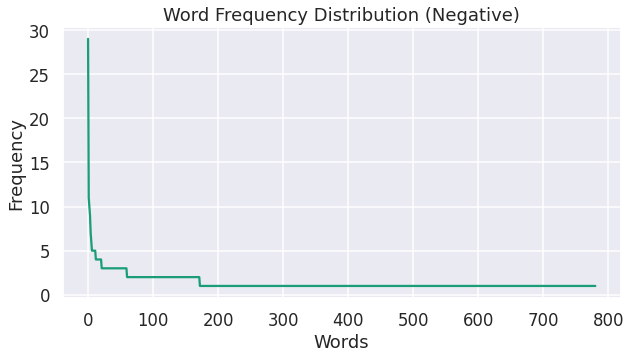

In [ ]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

In [ ]:

#comment_words = ''
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(pos_tokens)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [ ]:
from collections import Counter
word_could_dict=Counter(pos_tokens)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.show()
plt.savefig('Negative Words.png', bbox_inches='tight')
plt.close()

In [ ]:
files.download('Negative Words.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>